# **Importing Libraries:**

In [1]:
# Libraries for Data Manipulation
import numpy as np
import pandas as pd


# Libraries for Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt


# Libraries to Handle Warnings
import warnings
warnings.filterwarnings('ignore')


# Libraries to Handle Machine Learning Models
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier


# Model Evaluation Metrics
from sklearn.metrics import (
    f1_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
    classification_report,
)

# **Loading data**

In [2]:
x_train_scaled = pd.read_csv('./DATASET/EDA-DATASET/x_train_scaled.csv')
x_test_scaled = pd.read_csv('./DATASET/EDA-DATASET/x_test_scaled.csv')
y_train = pd.read_csv('./DATASET/EDA-DATASET/y_train.csv')
y_test = pd.read_csv('./DATASET/EDA-DATASET/y_test.csv')

### **Function to evaluate model**

In [3]:
def evaluate_model(y_test, y_pred, y_prob):
    accuracy = accuracy_score(
        y_test, 
        y_pred
    )
    
    precision = precision_score(
        y_test, 
        y_pred, 
        average='weighted'
    )
    
    recall = recall_score(
        y_test, 
        y_pred, 
        average='weighted'
    ) 
    
    f1 = f1_score(
        y_test, 
        y_pred, 
        average='weighted'
    ) 
    
    conf_matrix = confusion_matrix(
        y_test, 
        y_pred
    ) 
    
    class_report = classification_report(
        y_test, 
        y_pred
    ) 
    
    roc_auc = roc_auc_score(
        y_test, 
        y_prob, 
        multi_class='ovr', 
        average='weighted'
    )
    
     
    
    return accuracy, precision, recall, f1, conf_matrix, class_report, roc_auc

# **Hyper-Parameter Tuning Setups**

### **Parameter grid for Random Forest (RF)**

In [4]:
param_grid_rf = {
    # 'n_estimators': Number of trees in the Random Forest. 
    # Setting it to 100, a common choice for balancing performance and computational cost.
    'n_estimators': [100],
    
    # 'max_depth': Maximum depth of each tree.
    # 'None' allows trees to grow until all leaves are pure or have fewer than min_samples_split samples.
    # Setting an additional option '10' to limit depth and reduce overfitting.
    'max_depth': [None, 10],
    
    # 'min_samples_split': Minimum number of samples required to split an internal node.
    # Setting this to 2, the default, which allows nodes to be split as long as they have at least 2 samples.
    'min_samples_split': [2],
    
    # 'min_samples_leaf': Minimum number of samples required to be at a leaf node.
    # Setting to 1, allowing leaves to contain as few as 1 sample, providing the most granular splits.
    'min_samples_leaf': [1],
    
    # 'bootstrap': Whether bootstrap samples are used to build trees.
    # 'True' enables bootstrapping, which introduces randomness, a typical practice for Random Forests.
    'bootstrap': [True]
}


### **Perform GridSearchCV for Random Forest**

In [5]:
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),  # RandomForestClassifier as the model with a fixed random state for reproducibility
    param_grid=param_grid_rf,                           # Parameter grid defined earlier for RF
    cv=2,                                               # 2-fold cross-validation to split the training data for evaluation
    scoring='accuracy',                                 # accuracy as the evaluation metric
    verbose=1,                                          # Set verbosity level to show progress of the grid search
    n_jobs=-1                                           # Using all available CPU cores to parallelize the computation
)



# Fitting the grid search to the training data to find the best hyperparameters for RF
grid_search_rf.fit(x_train_scaled, y_train)



# Saving the best RF model with the optimal hyperparameters found
best_rf_model = grid_search_rf.best_estimator_


Fitting 2 folds for each of 2 candidates, totalling 4 fits


## **Running Predictions and Evaluation**

- **Predicting the class labels and probabilities using Random Forest model**

In [6]:
# Class labels
y_pred_rf = best_rf_model.predict(x_test_scaled)  

# Class probabilities
y_prob_rf = best_rf_model.predict_proba(x_test_scaled)  


# Evaluating the Random Forest model using various metrics defined above
accuracy_rf, precision_rf, recall_rf, f1_rf, conf_matrix_rf, class_report_rf, roc_auc_rf = evaluate_model(y_test, y_pred_rf, y_prob_rf)

## **Confusion Matrix**

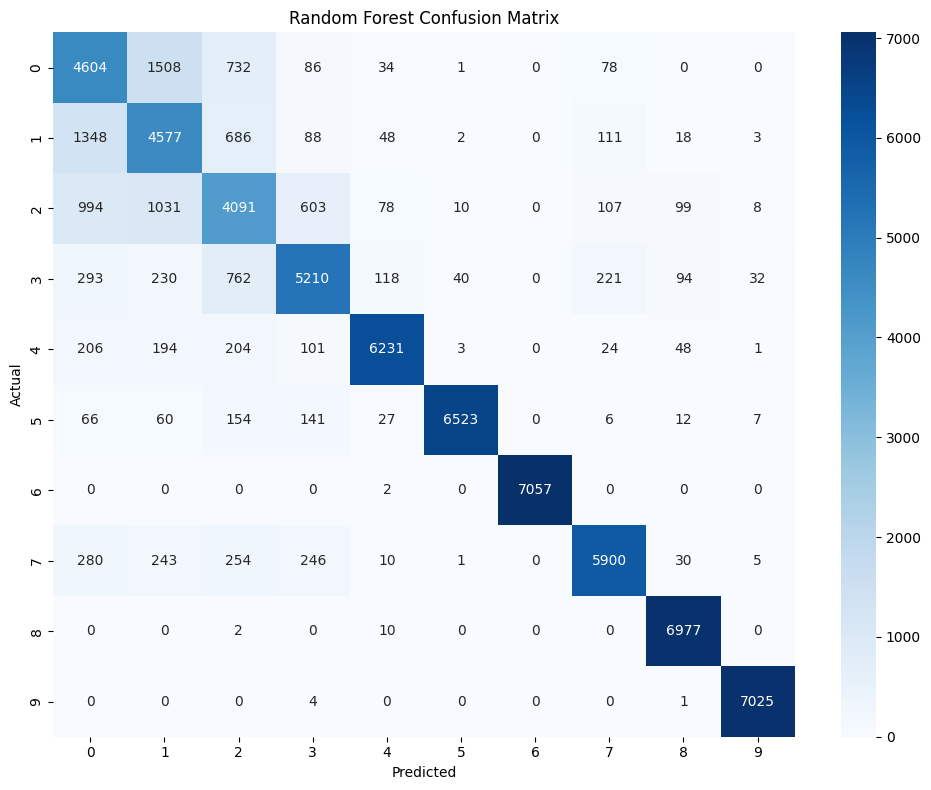

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))


sns.heatmap(
    conf_matrix_rf,
    annot=True,
    fmt='d',
    cmap='Blues',
    ax=ax
)

ax.set_title('Random Forest Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

## **ROC-AUC Curves**

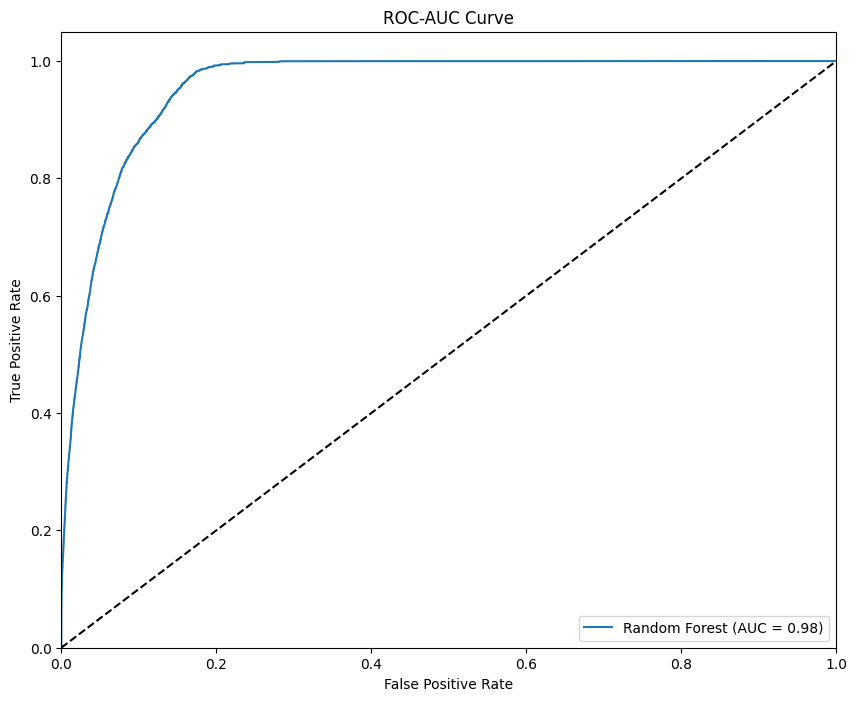

In [8]:
plt.figure(figsize=(10, 8))



fpr_rf, tpr_rf, _ = roc_curve(
    y_test,
    y_prob_rf[:, 1],
    pos_label=1
)



# ROC curve for Random Forest model
plt.plot(
    fpr_rf,
    tpr_rf,
    label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf)
)


# Plot a diagonal line representing a random classifier (50% chance)
# 'k--' == means black dashed line
plt.plot([0, 1], [0, 1], 'k--')  


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')


plt.legend(loc='lower right')


plt.show()

## **Model Summary Table**

In [9]:
summary = pd.DataFrame({
    'Model': ['Random Forest'],
    'Accuracy': [accuracy_rf],
    'Precision': [precision_rf],
    'Recall': [recall_rf],
    'F1 Score': [f1_rf],
    'ROC-AUC': [roc_auc_rf]
})


print("Model Comparison Summary:")
print(summary)

Model Comparison Summary:
           Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Random Forest  0.831357   0.838375  0.831357  0.833956  0.976437


### **Some key inferences:**

1. **Comparison of Models (KNN vs. Random Forest)**:
   - **Random Forest (AUC = 0.97)**: This model has a higher AUC score (0.97), which suggests it has a better ability to distinguish between the positive and negative classes. The curve is closer to the top-left corner of the plot, indicating high true positive rates and low false positive rates.
   - **KNN (AUC = 0.90)**: This model has a lower AUC score (0.90), meaning it is still performing well, but not as effectively as the Random Forest model. The curve is somewhat closer to the diagonal line, indicating that the model is less confident in distinguishing the classes compared to Random Forest.

2. **ROC Curve Shapes**:
   - The **Random Forest curve** rises steeply, indicating that it makes correct positive predictions early, leading to a higher true positive rate with fewer false positives.
   - The **KNN curve** rises more gradually, suggesting that it requires more decision boundary refinement to distinguish between classes effectively.

3. **Diagonal Line (Random Classifier)**:
   - The dashed diagonal line represents the performance of a random classifier (AUC = 0.5). Both models perform significantly better than this random classifier, which is expected since their AUC values are greater than 0.5.

4. **Conclusion**:
   - **Random Forest** is the better model in this case, as evidenced by its higher AUC score and the shape of its ROC curve. It seems to have a better ability to discriminate between classes.
   - **KNN** is still performing well but has slightly lower performance compared to Random Forest in terms of AUC and curve steepness.

This plot suggests that for our dataset, **Random Forest** would be the preferred model, though **KNN** might still be useful depending on the specific needs.